In [23]:
import numpy as np
from scipy import ndimage as ndi
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
from skimage import io, color, img_as_ubyte, util, segmentation, filters
from skimage.color import rgb2gray
import cv2
import warnings
warnings.filterwarnings('ignore')



In [24]:
def showimg(img, title="Obraz", verbose=False, cmap="gray"):        #obie funkcje Showimg oraz Show2imgs są autorstwa
    if verbose:                                                     #dr.inż Marcina Piekarczyka
        print(img.shape, img.dtype)
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.suptitle(title)
    plt.show()
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(10,10)):

    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

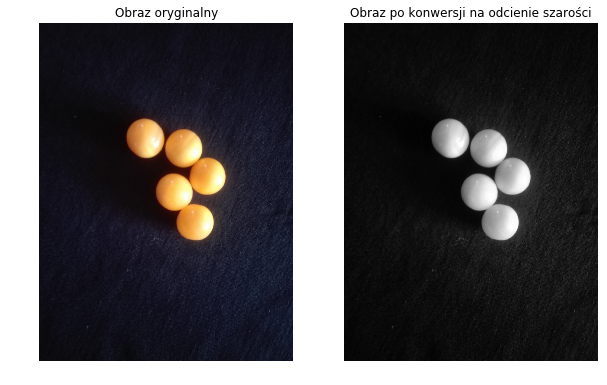

In [25]:
obraz = io.imread("dobre_zdjecie.jpg")            #dzięki funkcji io.imread czytam obraz
obrob = obraz.copy()                  #dokonuje kopii obrazu
obrob = img_as_ubyte(rgb2gray(obrob)) #zmiana na odcienie szarosci
show2imgs(obraz, obrob, title1='Obraz oryginalny', title2='Obraz po konwersji na odcienie szarości', size=(10,10))

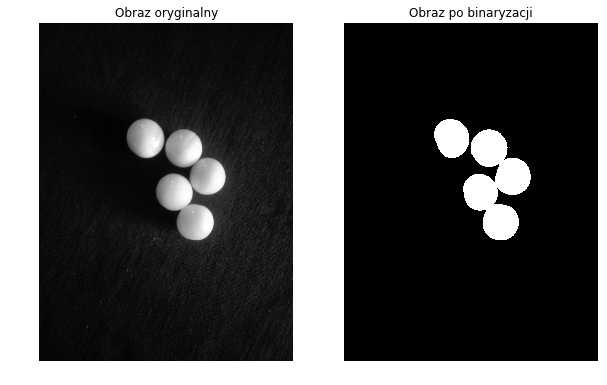

In [26]:
th = filters.threshold_otsu(obrob)                 
th, binar = cv2.threshold(obrob, thresh=th, maxval=255, type=cv2.THRESH_BINARY)      #binaryzacja metodą otsu
show2imgs(obrob, binar, title1='Obraz oryginalny', title2='Obraz po binaryzacji', size=(10,10))

In [27]:
def ile_procent(binar, tla, obiektu):               #ta funkcja oblicza jaki % obrazu stanowią obiekty
    obiektpx = 0                                    #(porównuje ilosc pikseli tła oraz obiektu)
    tlopx = 0
    for i in range(binar.shape[0]):
        for j in range(binar.shape[1]):
            if binar[i][j] == tla:
                tlopx += 1
            elif binar[i][j] == obiektu:
                obiektpx += 1
    procent=(obiektpx*100)/(tlopx+obiektpx)
    print("Procent obiektów na obrazie wynosi: ", procent,"%")

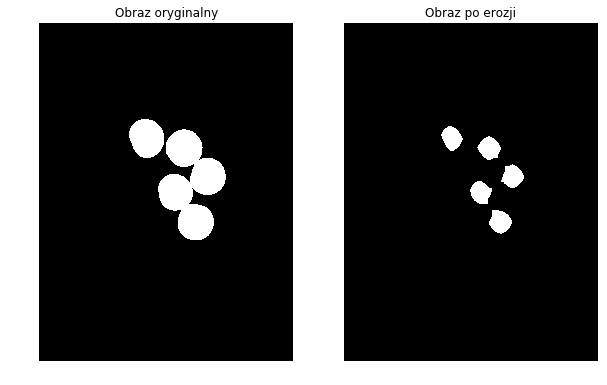

In [28]:
erozja = binar.copy()                            #dokonuje erozji krawędzi tak akby rozdzielic sklejone obiekty
kernel = np.ones((3,3),np.uint8)
erozja = cv2.erode(erozja, kernel=kernel, iterations=70)
show2imgs(binar, erozja, title1='Obraz oryginalny', title2='Obraz po erozji', size=(10,10))

In [29]:
label_objects, nb_labels = ndi.label(erozja)            # segmentacja z indeksacja 

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0

figures = mask_sizes[label_objects] 



In [30]:
def getFigure(labelledImage, objNumber):         # pobieram współrzędne niezerowych punktów danego obiektu 
                                                 # i wpisuje je do tablicy (listy)
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):  
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points

In [31]:
def computeBB(points):            # obliczam współczynnik Blaira-Blissa
    
    s = len(points)     
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))

In [32]:
def cog2(points):            
    mx=0
    my=0                   # obliczam srodek ciezkosci
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]


for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)

In [33]:
def computeFeret(points):                     # obliczam współczynnik feret
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)    

In [34]:
print("Wszystkich obiektów jest: ", nb_labels)      #Ostatnia funkcja wypisująca: ilość obiektów
ile_procent(binar,0,255)                            #wywoływana i wypisywana jest funkcja ile_procent 
z=1                                                 # getFigure, computeBB, computeFeret, len
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)            
    bb = computeBB(pts)
    feret = computeFeret(pts)
    print("Dla obiektu numer: ", z)
    print('Liczba punktow: ',len(pts),'\nSrodek ciezkosci: ', cog2(pts),'\nBlair-Bliss: ', bb,'\nFeret: ',feret, '\n---\n')
    z+=1

Wszystkich obiektów jest:  5
Procent obiektów na obrazie wynosi:  6.121355707593688 %
Dla obiektu numer:  1
Liczba punktow:  54792 
Srodek ciezkosci:  [1424.0789531318442, 1324.0273397576289] 
Blair-Bliss:  0.9814359616901048 
Feret:  1.1722846441947565 
---

Dla obiektu numer:  2
Liczba punktow:  58020 
Srodek ciezkosci:  [1550.237538779731, 1786.88719407101] 
Blair-Bliss:  0.9929410823063123 
Feret:  1.0206896551724138 
---

Dla obiektu numer:  3
Liczba punktow:  56604 
Srodek ciezkosci:  [1894.4792240831036, 2070.8945657550703] 
Blair-Bliss:  0.9907263591753315 
Feret:  1.0425531914893618 
---

Dla obiektu numer:  4
Liczba punktow:  54599 
Srodek ciezkosci:  [2094.0897452334293, 1678.4053737247934] 
Blair-Bliss:  0.9856574458800578 
Feret:  1.0746268656716418 
---

Dla obiektu numer:  5
Liczba punktow:  58802 
Srodek ciezkosci:  [2450.8314853236284, 1919.1762014897452] 
Blair-Bliss:  0.9908181398699981 
Feret:  1.0210526315789474 
---

